In [1]:
from pair_trading import *
import statsmodels.tsa.stattools as ts
from tqdm import tqdm
# import QuantConnect

In [2]:
# tickers = pd.read_csv('nasdaq_screener_1671416068616.csv')
# tickers 
# tk_ls = tickers.head(500).Symbol.to_list()

In [3]:
tickers = pd.read_csv('SP_500_Index.csv')
tk_ls = tickers.head(500).Symbol.to_list()

In [4]:
raw = yf.download(tk_ls, interval= '1d', start= '2021-01-01', end='2022-09-01', show_errors=True, progress=False)

# # raw = pd.read_csv('stock_raw.csv')
# dt = np.log(raw.loc[:,'Adj Close'])
# dt.to_csv('nasdaq_stock_raw.csv')
# print(dt.shape)
# dt.head()

In [ ]:
col_100 = raw['Adj Close'].columns[raw['Adj Close'].head(100).isna().sum()>0].tolist()


In [ ]:
dt = raw['Adj Close'].drop(col_100, axis = 1).iloc[:-1, :]
dt = dt.drop(dt.columns[dt.isna().sum()>0].tolist(), axis = 1)

In [ ]:
dt.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00,117.405220,15.13,149.533600,127.874939,96.813492,93.868271,316.730011,105.675865,34.900002,249.919220,...,106.900002,62.559101,37.604187,52.821632,97.479584,102.112701,146.518738,378.130005,40.739872,161.508575
2021-01-05 00:00:00,118.365128,15.43,149.372025,129.455978,97.814590,95.093895,322.600006,106.983368,35.040001,251.342010,...,110.190002,61.949322,39.416439,54.335033,97.362236,102.122360,149.053818,380.570007,41.385178,162.634064
2021-01-06 00:00:00,121.610992,15.52,158.001541,125.098267,96.969612,103.274544,321.609985,106.760612,36.580002,254.090057,...,110.849998,63.321308,40.422237,56.958908,101.469109,102.682022,153.301270,394.820007,46.035202,165.023239
2021-01-07 00:00:00,124.846962,15.38,159.351074,129.367020,98.007462,107.126534,323.559998,107.796936,36.240002,256.487366,...,109.750000,62.082706,40.739384,56.664097,106.074684,101.900406,152.392487,409.100006,47.439697,164.875198
2021-01-08 00:00:00,125.737595,15.13,161.622482,130.483627,98.521790,107.029266,324.059998,108.097168,36.439999,257.422852,...,109.029999,62.654369,41.192440,57.175117,104.999077,103.396080,152.057663,405.470001,46.234489,165.971069


In [ ]:
dt.columns[dt.isna().sum()>0]

Index([], dtype='object')

In [ ]:
# dt.to_csv('nasdaq500_train_202107_202207.csv')

adf_dt = np.log(dt).diff().iloc[1:,]
adf_rst = adf_dt.apply(lambda x: adfuller(x)[0], axis = 0).sort_values()
# adf_rst


In [ ]:
ind = adf_rst.loc[adf_rst < -7].index.tolist()

In [ ]:
len(ind)

476

In [ ]:
# m = adf_rst.shape[0]
# fdr = 0.01
# max([(x[0] + 1) if x[1]< fdr*(x[0] + 1)/m else 0 for x in enumerate(adf_rst.to_list())])
# # [adf_rst.to_list()]

In [ ]:
train = dt.loc[:, ind]/dt.loc[:,ind].iloc[0, :]
train.head()

,TXN,DVA,WELL,QRVO,AVGO,MCHP,AMAT,KLAC,LRCX,LYV,...,PARA,ACN,EVRG,ETR,NWL,MDT,LDOS,ARE,ED,PEG
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2021-01-05 00:00:00,1.007336,1.000429,1.005844,1.028313,1.006773,1.021942,1.031426,1.020974,1.034580,1.018820,...,1.010656,1.005693,0.997953,0.986634,1.006909,1.008016,1.000488,0.998946,0.988820,1.000179
2021-01-06 00:00:00,1.012329,1.034764,1.048377,1.045021,1.000564,1.041551,1.045585,1.018745,1.038638,1.027593,...,1.098361,1.016689,1.018047,1.002245,1.043759,1.024478,1.015131,0.955964,1.009907,1.021174
2021-01-07 00:00:00,1.035261,1.049013,1.027597,1.084938,1.042731,1.083977,1.088523,1.068605,1.076231,1.033112,...,1.096175,1.026281,0.990326,0.967656,1.042837,1.023100,1.016985,0.968203,0.989386,1.006639
2021-01-08 00:00:00,1.055110,1.063433,1.017532,1.089981,1.048022,1.074501,1.100034,1.087773,1.049391,1.039479,...,1.094536,1.030024,0.986047,0.974288,1.062644,1.031805,1.021671,0.971541,0.989669,1.028351


In [ ]:
%%time 
rst = {}
for n in tqdm(train.columns):
    x = train - train.loc[:, [n]].values
    if n not in rst:
        rst[n] = x.apply(lambda x: np.square(x).mean(), axis = 0).sort_values().head(11).to_dict()
        
    else:
        print(n)
    # break
# r = find_pairs(dt)
# r

100%|██████████| 476/476 [00:19<00:00, 24.71it/s]

CPU times: user 19.1 s, sys: 500 ms, total: 19.6 s
Wall time: 19.3 s


In [ ]:
rs_ls = []
for k in rst.items():
    for in_k in k[1].items():
        if k[0] == in_k[0]:
            continue
        elif (in_k[0], k[0]) in rs_ls:
            continue
        else:
            rs_ls.append((k[0], in_k[0]))

In [ ]:
candidates = sorted(rs_ls, key = lambda x: x[-1], reverse=False)
len(candidates)
# candidates

3407

In [ ]:

# dt = raw
dt = yf.download(train.columns.tolist(), interval= '1h', start= '2022-06-01', end='2022-09-01', show_errors=True, progress=True)

[*********************100%***********************]  476 of 476 completed

1 Failed download:
- GEN: No data found for this date range, symbol may be delisted


In [ ]:
thrd = 0.001
ls = []
for cand_stock in tqdm(candidates):
    a, b= cand_stock
    # dt = yf.download([a, b], interval= '1h', start= '2022-05-01', end='2022-11-01', show_errors=True, progress=False)
    if dt['Adj Close'].loc[:, [a, b]].isna().mean().max() <= 0.05:
        dt_new = dt['Adj Close'].loc[:, [a, b]].dropna()
    else:
        # print(dt['Adj Close'].loc[:, [a, b]].isna().mean())
        continue
    # dt_new = np.log(dt_new)
    x1 = np.log(dt_new.iloc[:, 0])
    x2 = np.log(dt_new.iloc[:, 1])
    try:
        p, lm = test_two_pairs(x1, x2)
        if lm.params[-1] > 0:
            ls.append((a, b, p))
    except:
        print(dt_new.head(1))
        continue

100%|██████████| 3407/3407 [00:15<00:00, 214.79it/s]


In [ ]:
def show_pairs(x1, x2, start= '2022-01-01', end= '2022-06-01', intv = '1h', plotting = False):
    raw = yf.download([x1, x2], interval= intv, start=start, show_errors=False).dropna()

    dt = raw.loc[start:end,:]
    # print(dt.tail(3))
    test_dt = raw.loc[end:,:]
    X = np.log(dt.loc[:,'Adj Close'].iloc[:, 0])
    # X = dt.loc[:,'Adj Close'].iloc[:, 0]
    X = sm.add_constant(X)
    model = sm.OLS(np.log(dt.loc[:,'Adj Close'].iloc[:, 1]), X)
    # model = sm.OLS((dt.loc[:,'Adj Close'].iloc[:, 1]), X)
    rst = model.fit()
    # print(rst.summary())
    
    params = rst.params

    test_X = np.log(test_dt.loc[:,'Adj Close'].iloc[:, 0])
    # test_X = (test_dt.loc[:,'Adj Close'].iloc[:, 0])

    test_X = sm.add_constant(test_X)
    test_rst = np.log(test_dt.loc[:,'Adj Close'].iloc[:, 1])- rst.predict(test_X)
    # test_rst = (test_dt.loc[:,'Adj Close'].iloc[:, 1])- rst.predict(test_X)

    if plotting:
        print(dt.Close.tail(3))
        temp_dt = (raw.loc[:,'Adj Close'])#/raw.loc[:,'Adj Close'].iloc[0])
        # temp_dt.plot(figsize = (19, 7))
        # plt.show()
        # diff = (temp_dt.iloc[:, 0] - (temp_dt.mean()[0]/temp_dt.mean()[1])*temp_dt.iloc[:, 1])
        # diff.plot(figsize = (19, 7))
        # plt.hlines(y=diff.mean(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        # plt.hlines(y = diff.mean()-2* diff.std(), colors='red',xmin = diff.index.min(), xmax = diff.index.max())
        # plt.hlines(y = diff.mean()+ 2* diff.std(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        # (dt.Close).plot(figsize = (19, 12))
        plt.show()
        print(rst.summary())
        diff = ((1/(1 + rst.params[1]))*temp_dt.iloc[:, 1] - (rst.params[1]/(1 + rst.params[1]))*temp_dt.iloc[:, 0])
        diff.plot(figsize = (19, 7))
        plt.hlines(y=diff.mean(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()-2* diff.std(), colors='red',xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()+ 2* diff.std(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.show()
        diff = (np.log(temp_dt.iloc[:, 1]) - (rst.params[1])*np.log(temp_dt.iloc[:, 0]))
        diff.plot(figsize = (19, 7))
        plt.hlines(y=diff.mean(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()-2* diff.std(), colors='red',xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()+ 2* diff.std(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()-3* diff.std(), colors='red',xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()+ 3* diff.std(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.show()
        return rst, dt, test_X, test_rst
    else:
        return rst
    
def adf_rst(rst):
    result = adfuller(rst)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    return result[1]

In [ ]:
# sec_ls = []

# for k, v in r.items():
#     x1 = k
#     for v_2 in v:
#         try:
#             x2 = v_2[0]
#             rst = show_pairs(x1, x2)
#             p = adf_rst(rst.resid.values)
#             if p < 0.01:
#                 sec_ls.append((k, x2, p))
#         except:
#             continue
#     # break

In [ ]:
def BH_test(ls, q = 0.05):
    sorted_ls = sorted(ls, key = lambda x: x[-1], reverse=False)
    m = len(ls)
    lab_ls = [(x[0] + 1) if x[1][-1]< q*(x[0] + 1)/m else 0 for x in enumerate(sorted_ls) ]
    try:
        max_num = max(lab_ls)
        print(max_num)
    except:
        return []
    return sorted_ls[:max_num]
    

In [ ]:
print(len(ls))
BH_test(ls, q=0.1)
# len(ls)

3118
16


[('ORCL', 'DHR', 8.735423206005161e-05),
 ('TXT', 'FRT', 9.530505904628912e-05),
 ('ANSS', 'AMZN', 9.77534237018759e-05),
 ('VRSN', 'AMZN', 0.00010229127975035884),
 ('CCI', 'AMT', 0.00011198959341655629),
 ('META', 'DISH', 0.00012061681425790342),
 ('MKTX', 'VFC', 0.00013797325632400738),
 ('PAYC', 'AMZN', 0.00014925247256903848),
 ('AMGN', 'GL', 0.00015393981931165234),
 ('BALL', 'AMZN', 0.00020159073030963845),
 ('DVA', 'AMZN', 0.00022201788750308033),
 ('TGT', 'CARR', 0.00024321472061887602),
 ('DTE', 'EVRG', 0.0003329571802723108),
 ('ZBRA', 'EBAY', 0.0003695350722894381),
 ('MCD', 'PEP', 0.0004246653471951838),
 ('CHTR', 'AMZN', 0.00043935194911474057)]

[*********************100%***********************]  2 of 2 completed
                            DHR       ORCL
Datetime                                  
2022-09-01 13:30:00  272.704987  74.760002
2022-09-01 14:30:00  272.119995  74.959999
2022-09-01 15:30:00  273.790009  75.294998
                            OLS Regression Results                            
Dep. Variable:                   ORCL   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     3733.
Date:                Wed, 28 Dec 2022   Prob (F-statistic):          8.42e-202
Time:                        12:29:48   Log-Likelihood:                 1077.0
No. Observations:                 392   AIC:                            -2150.
Df Residuals:                     390   BIC:                            -2142.
Df Model:                           1                                         
Covar

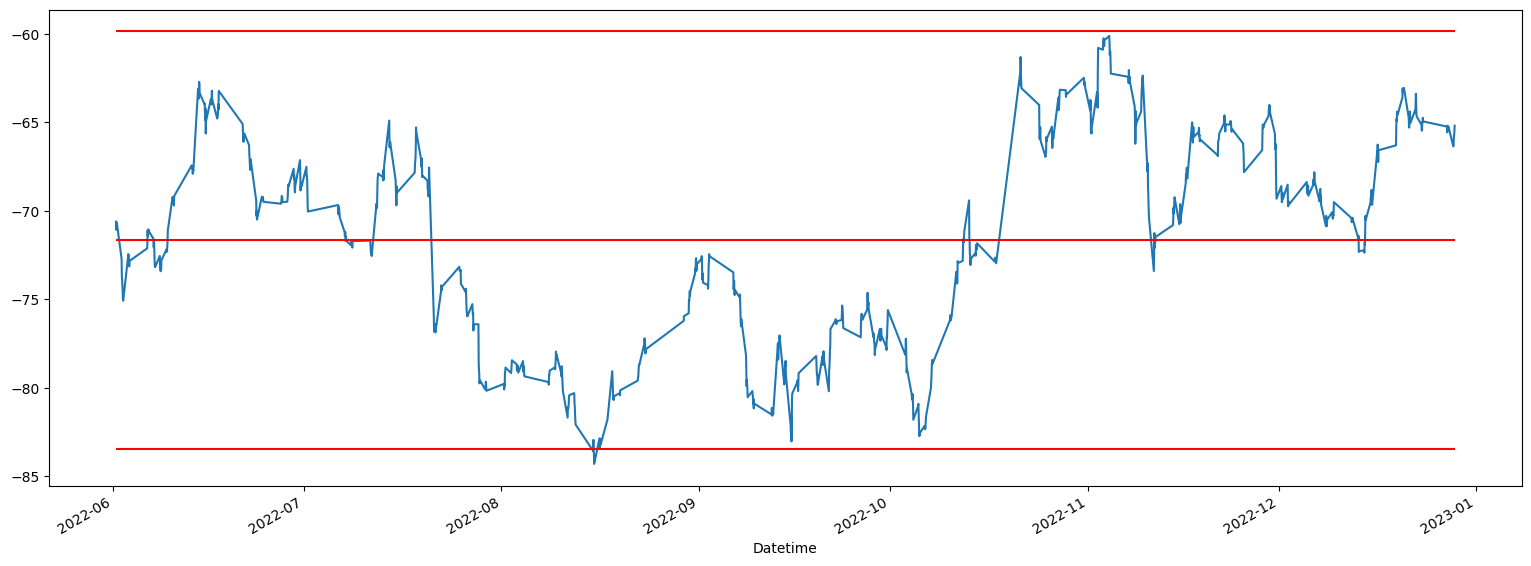

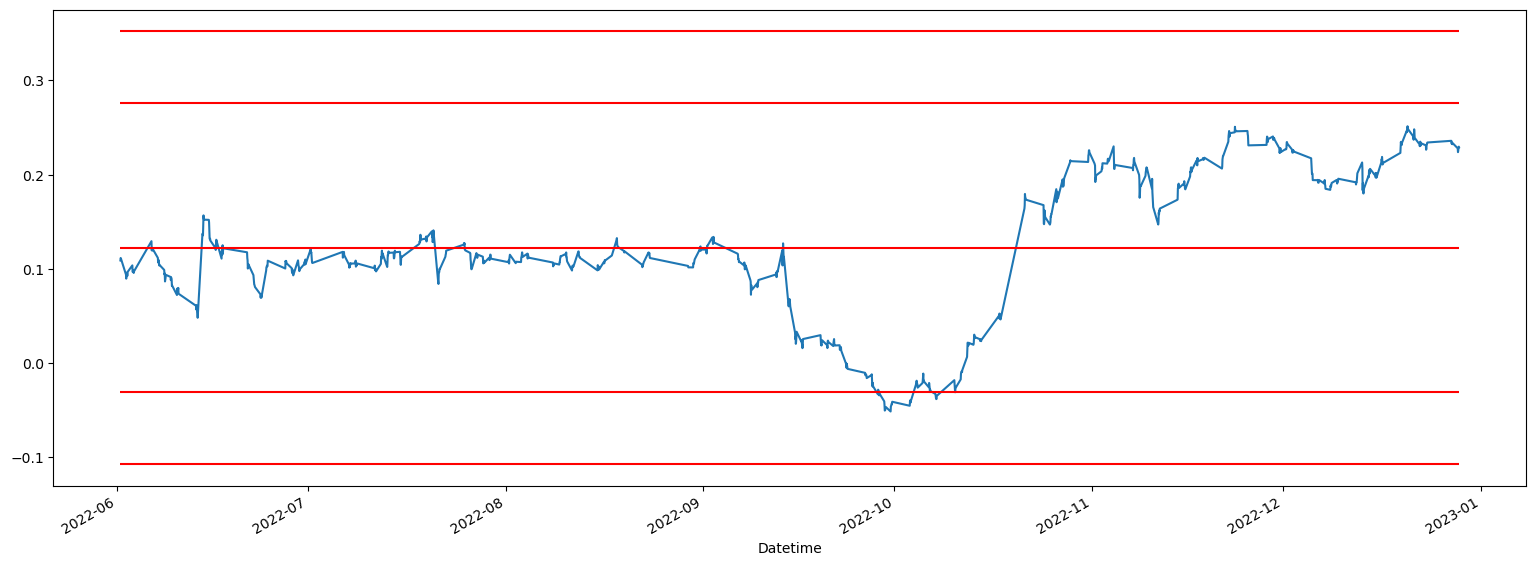

ADF Statistic: -4.788864
p-value: 0.000057


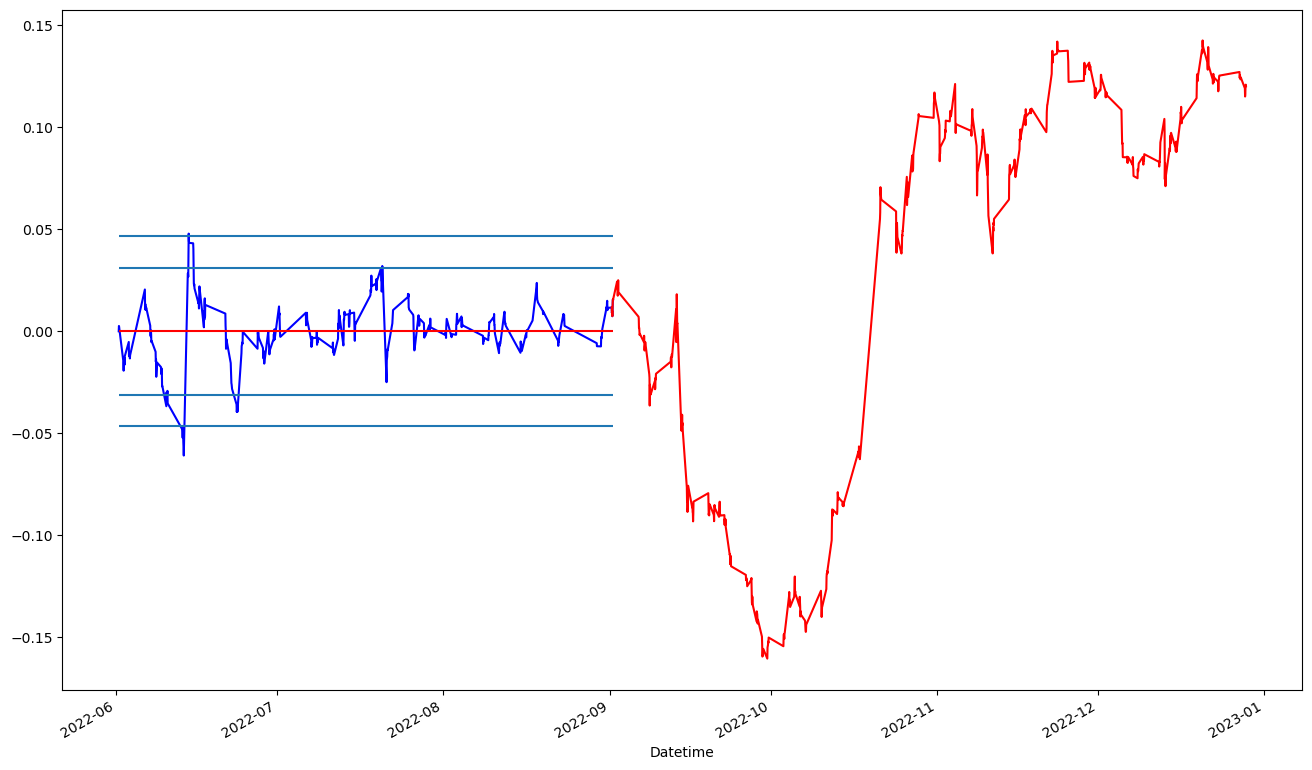

<AxesSubplot: >

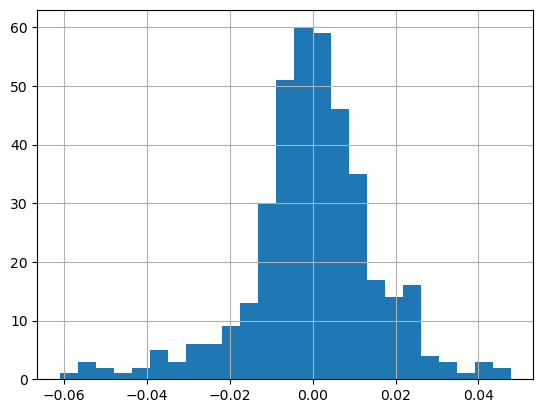

In [ ]:
x1, x2 = 'ORCL', 'DHR'
# 'IBM', 'JNJ'
# 'HST', 'KMI'
# 'XYL', 'A'
# 'fitb', 'rf'
# 'AEE', 'AEP'

# 'dow', 'lyb'

rst, dt, test_X, test_rst = show_pairs(x1=x1, x2=x2,start= '2022-06-01', end= '2022-09-01', plotting=True, intv='1h')
adf_rst(rst.resid.values)
from turtle import color


plt.figure(figsize=(16, 10))
(rst.resid).plot(color= 'blue')
plt.plot(test_rst,color = 'red')
plt.hlines(y=0, colors='red', xmin=min(dt.index), xmax=max(dt.index))
plt.hlines(y=2*rst.resid.std(), xmin=min(dt.index), xmax=max(dt.index))
plt.hlines(y=-2*rst.resid.std(), xmin=min(dt.index), xmax=max(dt.index))
plt.hlines(y=3*rst.resid.std(), xmin=min(dt.index), xmax=max(dt.index))
plt.hlines(y=-3*rst.resid.std(), xmin=min(dt.index), xmax=max(dt.index))
plt.show()
rst.resid.hist(bins = 25)

In [ ]:
np.exp(1.68)

5.3655559711219745